In [1]:
import pandas as pd
import datetime
import asyncpraw
import os
import time

In [2]:
full = pd.read_csv(f'wallstreetbets_posts.csv')[['created_utc', 'id', 'score', 'num_comments']]
jan1 = datetime.datetime(year=2021, month=1, day=1)
feb1 = datetime.datetime(year=2021, month=2, day=1)
full['dt'] = full.created_utc.apply(datetime.datetime.fromtimestamp)
jan = full[(full.dt >= jan1) & (full.dt <= feb1)]
# free memory
del full

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (4,81,82,83,84) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
sample = pd.read_csv('data/start=2021-01-01_00:00:00_end=2021-02-01_00:00:00_n=446_seed=0/submissions_with_praw.csv')
sample['dt'] = sample.created_utc.apply(datetime.datetime.fromtimestamp)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (78,81,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,102,105,106,107) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
wsb = sample[sample.subreddit == 'wallstreetbets']

In [5]:
len(jan), len(wsb)*100

(494491, 535000)

Looks like the post count is not too far off, although
the actual value is outside the amount suggested by 95% proportion confidence interval.

*Note that post deletion may have played a role here, re-running the sample could verify this.*

In [6]:
jan['date'] = jan['dt'].dt.date
jan['weekday'] = jan['dt'].dt.weekday
jan['day'] = jan['dt'].dt.day

wsb['date'] = wsb['dt'].dt.date
wsb['weekday'] = wsb['dt'].dt.weekday
wsb['day'] = wsb['dt'].dt.day

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [7]:
jan.date.value_counts()

2021-01-28    162852
2021-01-29    113716
2021-01-30     55890
2021-01-31     45969
2021-01-27     43162
2021-01-25     14539
2021-01-26      8534
2021-01-22      6561
2021-01-15      3688
2021-01-23      3582
2021-01-19      3430
2021-01-21      3245
2021-01-14      3140
2021-01-20      3009
2021-01-24      2804
2021-01-13      2724
2021-01-07      1699
2021-01-08      1651
2021-01-18      1593
2021-01-16      1549
2021-01-11      1409
2021-01-12      1235
2021-01-04      1228
2021-01-06      1225
2021-01-05      1062
2021-01-17       991
2021-01-09       911
2021-01-01       888
2021-01-10       866
2021-01-02       725
2021-01-03       613
2021-02-01         1
Name: date, dtype: int64

In [8]:
submissions_per_day = jan.day.value_counts().sort_index().rename(index='exact')
est_submissions_per_day = wsb.day.value_counts().sort_index().rename(index='estimated') * 100

comparison = pd.concat(
    [submissions_per_day, est_submissions_per_day], axis=1
)
comparison


,exact,estimated
1,889,900
2,725,900
3,613,600
4,1228,1300
5,1062,400
6,1225,2500
7,1699,1100
8,1651,900
9,911,800
10,866,700


In [9]:
comparison.diff(axis=1)

,exact,estimated
1,NaN,11
2,NaN,175
3,NaN,-13
4,NaN,72
5,NaN,-662
6,NaN,1275
7,NaN,-599
8,NaN,-751
9,NaN,-111
10,NaN,-166


Estimated "fraction per day" minus exact "fraction per day"

Positive means the sample overstimates
Negative means the sample underestimates

<AxesSubplot:>

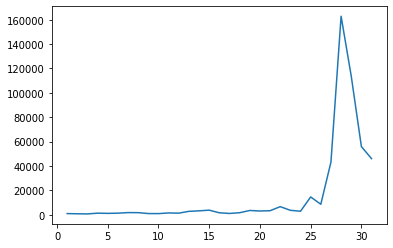

In [10]:
submissions_per_day.plot()

<AxesSubplot:>

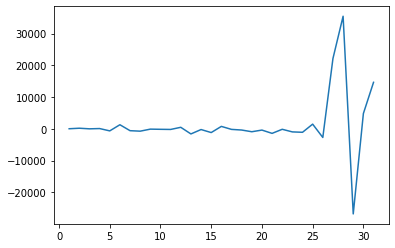

In [11]:
comparison.diff(axis=1)['estimated'].plot()

So our estimates have some large errors on the days in which activity skyrocketed.
But in terms of percent change (below), this isn't actually so bad!

<AxesSubplot:>

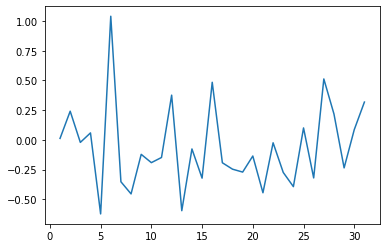

In [12]:
comparison.pct_change(axis=1)['estimated'].plot()

# Num comments

Below, we compare descriptive stats for num_comments (pushshift). For pushshift scores (i.e. "initial" score)
the estimate is pretty close. For comments, however, our estimate is quite off!

While this may be related to comment deletion (verifiable by recollecting data), it's likely also
just related to the extreme skew of the `num_comments` variable. 

In [13]:
cols = ['score' , 'num_comments']
pd.concat(
    [jan[cols].describe(), wsb[cols].describe()], axis=1
)

,score,num_comments,score,num_comments
count,494491.000000,494491.000000,5350.000000,5350.000000
mean,7.121495,14.532105,5.210280,3.599252
std,387.936323,744.362477,162.751611,32.111383
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000
max,83793.000000,150791.000000,11251.000000,1575.000000


In [14]:
cols = ['score' , 'num_comments']
pd.concat(
    [jan[cols].skew(), wsb[cols].skew()], axis=1
)

,0,1
score,117.855592,63.347673
num_comments,113.677287,28.304375


<AxesSubplot:>

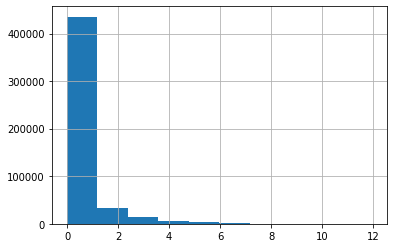

In [15]:
import numpy as np
jan.num_comments.apply(np.log1p).hist()

To compare PRAW scores quickly,
we'll take an actual random sample from the full data
and hit PRAW scores. Otherwise, we run into the same problem we wanted
to solve all along (avoiding make API calls for every single post).

For a quick comparison, we'll do 1 random draws of 5% of submissions, and calculate the mean `praw_score`
using each.

In [16]:
# init PRAW reddit object. Used to grab most up-to-date post scores.
reddit = asyncpraw.Reddit(
     client_id=os.environ['CLIENT_ID'],
     client_secret=os.environ['CLIENT_SECRET'],
     user_agent=os.environ['USER_AGENT']
 )

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
samps = {}
for random_state in [0]:
    times = []
    praw_scores = {}
    praw_num_comments = {}
    num_chunks = 0
    samp = jan.sample(frac=0.05, random_state=random_state)
    print('length of sample', len(samp))
    for chunk in chunks(samp.id, 100):
        t1 = time.time()
        num_chunks += 1
        if num_chunks % 50 == 0:
            print('starting a chunk', len(chunk), len(praw_scores))
        list_of_ids = []
        for submission_id in chunk:
            list_of_ids.append("t3_{}".format(submission_id))
        
        if list_of_ids:
            reddit_submissions = reddit.info(fullnames=list_of_ids)
            time.sleep(1)
            async for submission in reddit_submissions:
                praw_scores[submission.id] = submission.score
                praw_num_comments[submission.id] = submission.num_comments
        tic = time.time() - t1
        times.append(tic)
    samp['praw_score'] = samp.id.map(praw_scores)
    samp['praw_num_comments'] = samp.id.map(praw_num_comments)
    samps[random_state] = samp
    print(samp.praw_score.mean(), samp.praw_num_comments.mean())
    #submissions.to_csv('wallstreetbets_posts_mod.csv')

length of sample 24725


In [ ]:
import numpy as np
np.mean([x.praw_score.mean() for x in samps])

NameError: name 'samps' is not defined

Simulate random 1% draws from the full dataset to see if our
underestimate of `num_comments` is plausible.

In [ ]:
means = []
for random_state in range(0, 100):
    means.append(jan.sample(frac=0.01, random_state=random_state).num_comments.mean())
print(pd.Series(means).describe())

count    100.000000
mean      14.439100
std       11.218245
min        3.381800
25%        6.883771
50%       10.534580
75%       17.432963
max       62.274621
dtype: float64


<AxesSubplot:>

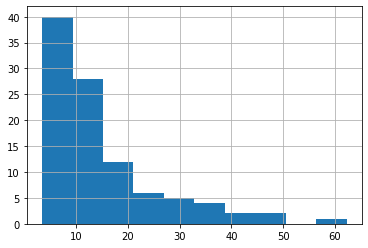

In [ ]:
pd.Series(means).hist()

Above results suggest our actual estimate (3.3) is at the very bottom end
of what we expect taking a straight random sample from full data.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9d8dd8e7-abf2-4721-84cd-03779d208ef5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>